# Learning Once and for All - On the Input Sensitivity of Configurable Systems

### This notebook details the main results presented in the paper submitted to the International Conference of Software Engineering.

#### Warning; Before launching the notebook, make sure you have installed all the packages in your python environment
#### To do that,  open a terminal in the replication folder, and use the requirements.txt file to download the libraries needed for this script :
`pip3 install -r requirements.txt`
#### If it worked, you should be able to launch the following cell to import libraries.

In [1]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans

# we use it to interact with the file system
import os
# compute time
from time import time

# Neural network high level framework
import keras
# Sequential is a sequence of blocs
# Input deals with the data fed to the network
from keras.models import Sequential,Input,Model
# Dense is a feedforward layer with fully connected nodes
# Dropout allows to keep part of data, and to "drop out" a the rest
# Flatten makes the data "flat", i.e. in one dimension
from keras.layers import Dense, Dropout, Flatten
# Conv -> convolution, MaxPooling is relative to Pooling
# Activation if the function composing the data in output of a layer
from keras.layers import Conv2D, MaxPooling2D, Activation

Using TensorFlow backend.


#### Now, we import data

In [2]:
#because x264 output is "m:s", where m is the number of minutes and s the number of seconds 
# we define a function to convert this format into the number of seconds
def elapsedtime_to_sec(el):
    tab = el.split(":")
    return float(tab[0])*60+float(tab[1])

# the data folder, see the markdown there for additional explanations
res_dir = "../../data/ugc/res_ugc/"

# the list of videos names, e.g. Animation_360P-3e40
# we sort the list so we keep the same ids between two launches
v_names = sorted(os.listdir(res_dir)) 

# the list of measurements
listVideo = []

# we add each dataset in the list, converting the time to the right format
# third line asserts that the measures are complete
for v in v_names:
    data = pd.read_table(res_dir+v, delimiter = ',')
    data['etime'] = [*map(elapsedtime_to_sec, data['elapsedtime'])]
    assert data.shape == (201,34), v
    listVideo.append(data)

In [3]:
print(" We consider ", len(listVideo), " videos")

 We consider  1397  videos


#### Just a few words about the time needed to compute the data; about a month is needed to fully replicate the experience

In [4]:
totalTime = np.sum([np.sum(vid["etime"]) for vid in listVideo])
print("Hours : "+str(totalTime/(3600)))
print("Days : "+str(totalTime/(24*3600)))

Hours : 810.7560972222223
Days : 33.781504050925925


#### Our focus in this paper is the bitrate, in kilobits per second

In [5]:
#our variable of interest
predDimension = "kbs"

for i in range(len(listVideo)):
    sizes = listVideo[i][predDimension]
    ind = sorted(range(len(sizes)), key=lambda k: sizes[k])
    listVideo[i]['ranking'] = ind

# In the paper, here starts Section II

# RQ1 - Do Input Videos Change Performances of x264 Configurations?

## RQ1.1 - Do software performances stay consistent across inputs?

#### A-] For this research question, we computed a matrix of Spearman correlations between each pair of input videos.

Other alternatives : Kullback-Leibler divergences to detect outliers, and Pearson correlation to compute only linear correlations 

In [6]:
# number of videos
nbVideos = len(listVideo)
# matrix of coorelations
corrSpearman = [[0 for x in range(nbVideos)] for y in range(nbVideos)]

for i in range(nbVideos):
    for j in range(nbVideos):
        # A distribution of bitrates will have a correlaiton of 1 with itself
        if (i == j):
            corrSpearman[i][j] = 1
        else:
            # we compute the Spearman correlation between the input video i and the input video j
            corrSpearman[i][j] = sc.spearmanr(listVideo[i][predDimension],
                                            listVideo[j][predDimension]).correlation

#### Here is the distribution depicted in figure 1, on the bottom left; we removed the diagonal $i!=j$ in the following code.

In [7]:
corrDescription = [corrSpearman[i][j] for i in range(nbVideos) for j in range(nbVideos) if i >j]
pd.Series(corrDescription).describe()

count    975106.000000
mean          0.566596
std           0.288894
min          -0.694315
25%           0.394656
50%           0.630336
75%           0.794686
max           0.997228
dtype: float64

#### Few statistics about input videos, mentioned in the text

#### A small detail; in the paper, when we mention the video having the id $i$,  it means the $(i+1)^{th}$ video of the list, because the first input has the index 0

In [8]:
min_val = 1
ind_i = 0
ind_j = 0
for i in range(len(corrSpearman)):
    for j in range(len(corrSpearman[0])):
        if corrSpearman[i][j] < min_val:
            min_val = corrSpearman[i][j]
            ind_i = i
            ind_j = j

print("Value : ", min_val)
print("i : ", ind_i, ", j : ", ind_j)

Value :  -0.69431464627679
i :  503 , j :  9


In [9]:
corrSpearman[378][1192]

0.41941047373724333

In [10]:
corrSpearman[314][1192]

0.2103270357298852

In [11]:
corrSpearman[378][314]

0.8963298633897601

#### "For 95% of the videos, it is always possible to find another video having a correlation higher than 0.92" -> here is the proof 

In [12]:
argm = [np.max([k for k in corrSpearman[i] if k <1]) for i in range(len(corrSpearman))]
pd.Series(argm).describe()

count    1397.000000
mean        0.969512
std         0.022919
min         0.803902
25%         0.963099
50%         0.975897
75%         0.983906
max         0.997228
dtype: float64

In [13]:
np.percentile(argm, 5)

0.9216475343513424

## Figure 1

#### Now, let's compute figure 1!

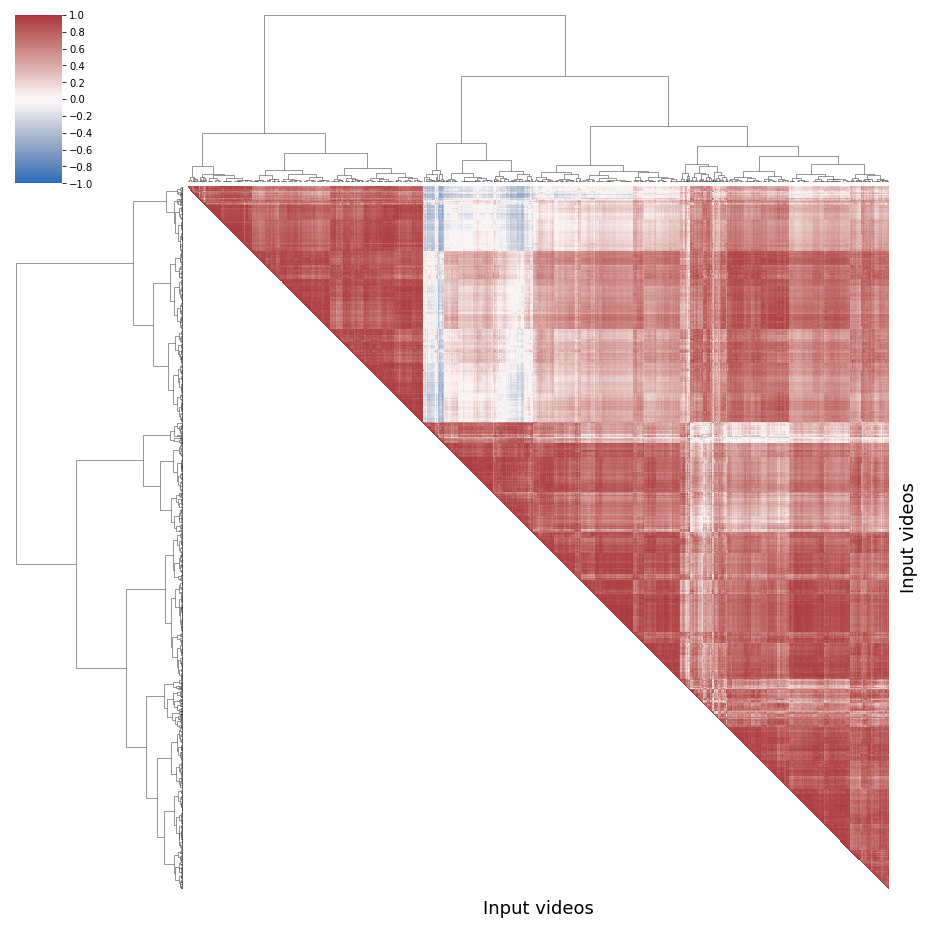

In [14]:
# the results directory
result_dir = "../../results/"

# We define a function to plot the correlogram
def plot_correlationmatrix_dendogram(corr, img_name, ticks, method= 'ward'):
    # inputs : a correlation matrix, or a matrix with quantitative values
    # a name for the image
    # the ticks to plot on axis
    # the aggregation method
    # output : a plot of an ordered correlogram with dendograms
    
    # we transform our matrix into a dataframe
    df = pd.DataFrame(corr)
    
    # group the videos, we choose the ward method 
    # single link method (minimum of distance) leads to numerous tiny clusters
    # centroid or average tend to split homogeneous clusters
    # and complete link aggregates unbalanced groups. 
    links = linkage(df, method=method,)
    order = leaves_list(links)
    
    # we order the correlation following the aggregation clustering
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(nbVideos):
        for j in range(nbVideos):
            # Generate a mask for the upper triangle
            if i>j:
                mask[order[i]][order[j]] = True
    
    # seaborn clustermap plots a nice graph combining the correlogram and dendograms
    # cmap is the colormap, mask hides the lower triangular, method is the aggregation method,
    # linewidth is set to 0 because otherwise we can't see squre colors
    # figsize is the size of figure
    # we cannot print 1400 ticks, wo we hide them
    # to not fool the reviewers, we set the minimum to -1, to plot the full range of correlation
    # -0.69 would give a false impression of high input sensitivity
    g = sns.clustermap(df, cmap="vlag", mask=mask, method=method,
                   linewidths=0, figsize=(13, 13), cbar_kws={"ticks":ticks}, vmin =-1)
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.tick_params(right=False, bottom=False)
    # abcissa and ordered labels
    g.ax_heatmap.set_xlabel("Input videos", fontsize = 18)
    g.ax_heatmap.set_ylabel("Input videos", fontsize = 18)
    # we save the figure in the result folder
    plt.savefig(result_dir+img_name)
    # we show the graph
    plt.show()
    
    # finally we cut the dendogram to have 4 groups, and return thietr indexes
    return cut_tree(links, n_clusters = 4)

group_no_ordered = plot_correlationmatrix_dendogram(corrSpearman, 
                                 "corrmatrix-ugc-dendo-Spearman-" + predDimension + ".pdf",
                                 [k/5 for k in np.arange(-10,10,1)], method='ward')

#### To match the increasing number of groups to the order of the figure (from the left to the right), we change the ids of groups

In [15]:
map_group = [2, 0, 3, 1]

def f(gr):
    return map_group[int(gr)]

# we apply this mapping
groups = np.array([*map(f, group_no_ordered)],int)

print("Group 1 contains", sum(groups==0), "input videos.")
print("Group 2 contains", sum(groups==1), "input videos.")
print("Group 3 contains", sum(groups==2), "input videos.")
print("Group 4 contains", sum(groups==3), "input videos.")

Group 1 contains 470 input videos.
Group 2 contains 219 input videos.
Group 3 contains 292 input videos.
Group 4 contains 416 input videos.


### B-] We also study rankings of configurations

#### First, we compute the rankings

In [16]:
# first example ; we compute the rankings of the bitrate distribution for the first input video
bitrates = listVideo[0][predDimension]
# sorted rankings for the bitrates distribution (0: minimal, 200 : maximal)
ind = sorted(range(len(bitrates)), key=lambda k: bitrates[k])
# df
rankings = pd.DataFrame({"index" : range(201), "video0" : ind}).set_index("index")

for i in np.arange(1,len(listVideo),1):
    bitrates = listVideo[i][predDimension]
    ind = sorted(range(len(bitrates)), key=lambda k: bitrates[k])
    rankings["video"+str(i)] = ind

rankings.head()

,video0,video1,video2,video3,video4,video5,video6,video7,video8,video9,...,video1387,video1388,video1389,video1390,video1391,video1392,video1393,video1394,video1395,video1396
index,,,,,,,,,,,,,,,,,,,,,
0,166,91,104,171,169,89,26,161,171,104,...,104,169,104,164,170,169,104,170,175,169
1,164,104,105,130,168,170,27,160,32,171,...,32,166,46,175,171,168,171,171,193,168
2,169,100,100,131,170,169,28,163,161,60,...,171,170,190,193,169,165,60,169,164,123
3,165,102,102,132,165,168,21,171,160,32,...,36,165,176,92,184,123,32,60,39,159
4,168,108,108,32,123,165,20,130,163,130,...,35,168,187,112,179,159,4,177,23,170


#### To get the most "unstable" ranking, we take the configuration having the highest standard deviation.

Config min std :  200
Config max std :  16
Config med std :  58.682728061838525


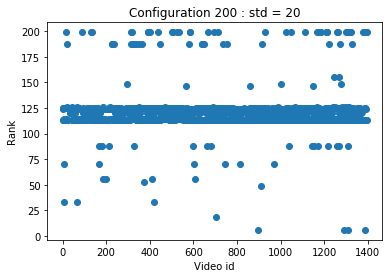

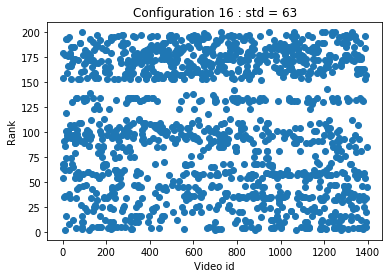

In [17]:
# standard deviations for rankings of the 201 configurations
stds = [np.std(rankings.loc[i,:]) for i in range(len(rankings.index))]
print("Config min std : ", np.argmin(stds))
print("Config max std : ", np.argmax(stds))
print("Config med std : ", np.median(stds))

# depicts the most stable configuration ranking across inputs
plt.scatter(range(len(rankings.columns)), rankings.loc[np.argmin(stds), :])
plt.ylabel("Rank")
plt.xlabel("Video id")
plt.title("Configuration "+str(np.argmin(stds))+" : std = "+str(int(np.round(np.min(stds)))))
plt.savefig("../../results/config_min_std_ranking.png")
plt.show()

# depicts the most input sensitive configuration
plt.scatter(range(len(rankings.columns)), rankings.loc[np.argmax(stds), :])
plt.ylabel("Rank")
plt.xlabel("Video id")
plt.title("Configuration "+str(np.argmax(stds))+" : std = "+str(int(np.round(np.max(stds)))))
plt.savefig("../../results/config_max_std_ranking.png")
plt.show()

#### Some statistics (not mentioned in the text)

In [18]:
print("For config. 200, ", int(np.sum([1  for j in range(len(rankings.loc[np.argmin(stds),:])) 
              if rankings.loc[np.argmin(stds),:][j] > 105 and rankings.loc[np.argmin(stds),:][j] < 130])
      /len(rankings.loc[np.argmin(stds),:])*100),"% of configurations are between 105 and 130!")

For config. 200,  92 % of configurations are between 105 and 130!


In [19]:
np.where(rankings.loc[np.argmin(stds),:] == np.min(rankings.loc[np.argmin(stds),:]))

(array([ 897, 1289, 1311, 1387]),)

In [20]:
np.max(rankings.loc[np.argmax(stds),:])

200

In [21]:
np.where(rankings.loc[np.argmax(stds),:] == np.min(rankings.loc[np.argmax(stds),:]))

(array([  11,  121,  698,  883, 1071, 1279]),)

In [22]:
np.max(rankings.loc[np.argmax(stds),:])

200

In [23]:
np.where(rankings.loc[np.argmin(stds),:] == np.max(rankings.loc[np.argmin(stds),:]))

(array([  15,   91,  132,  134,  316,  318,  390,  394,  402,  437,  503,
         507,  525,  535,  583,  585,  667,  696,  715,  927, 1025, 1046,
        1113, 1167, 1175, 1185, 1208, 1211, 1215, 1259, 1262, 1298, 1304,
        1312, 1318, 1322, 1380, 1390, 1395]),)

#### Rankings distributions

In [24]:
pd.Series(rankings.loc[np.argmax(stds),:]).describe()

count    1397.000000
mean      107.542591
std        62.835841
min         2.000000
25%        54.000000
50%       102.000000
75%       171.000000
max       200.000000
Name: 16, dtype: float64

In [25]:
pd.Series(rankings.loc[np.argmin(stds),:]).describe()

count    1397.000000
mean      120.461704
std        19.612164
min         6.000000
25%       113.000000
50%       120.000000
75%       124.000000
max       199.000000
Name: 200, dtype: float64

## RQ1-2- Are there some configuration options more sensitive to input videos?

#### A-] For RQ1-2, we compute the feature importances of configuration options for each video

In [26]:
# the list of p = 24 features
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", 
                "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]

# we added the bitrates to predict it
to_keep = [k for k in listFeatures]
to_keep.append(predDimension)

# Those feature have values, so we had to transform them into quantitative variables
# They do not change a lot (in terms of feature importances and feature effects)
# But if they did, we would have transformed them into a set of dummies
# see https://www.xlstat.com/en/solutions/features/complete-disjuncive-tables-creating-dummy-variables
categorial = ['analyse', 'me', 'direct']

# A function that computes features importances 
# relative to a random forest learning the bitrate of a video compression
# (reused for each group)
def compute_Importances(listVid, id_short = None):
    # input : a list of videos
    # output : a dataframe of feature importances
    
    # we can give a list of ids, to work on a subset of the videos (e.g. a group)
    if not id_short:
        id_short = np.arange(0, len(listVid), 1)
    
    # the final list of importances
    listImportances = []

    # for each video of the list
    for id_video in range(len(listVid)):
        
        # we replace missing numbers by 0
        df = listVid[id_video][to_keep].replace(to_replace = "None", value = '0')
        # two values for deblock, "1:0:0" and "0:0:0", 
        # we just take the first character as a int
        df['deblock'] = [int(val[0]) for val in df['deblock']]
        
        for col in df.columns:
            # we center and reduce the quantitative variables
            # i.e substract the mean, and divide by the standard deviation
            # to avoid the scale of the vars to interfere with the learning process
            if col not in categorial:
                arr_col = np.array(df[col], int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                # if the variable is categorial
                if col not in [predDimension, 'ranking']:
                    df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                    arr_col = np.array(df[col], int)
                    arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                    df[col] = arr_col
        
        # for each video, we train a model
        clf = RandomForestRegressor(n_estimators=200)
        # we use all the configuration options as predicting variables
        X = df.drop([predDimension], axis=1)
        # and the bitrate distribution of the video as a variable to predict
        y = df[predDimension]
        # we train the model on all the data (not train-test since we don't use the model)
        clf.fit(X, y)
        
        # we add feature importances to the list
        listImportances.append(clf.feature_importances_)
    # final dataframe of feature importances
    res = pd.DataFrame({'features' : listFeatures})
    
    # significative numbers p, cs = 10^p
    cs = 100
    
    # we add the feature imps to the dataframe 
    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = np.round(cs*listImportances[id_video])/cs
    
    # transpose it
    res = res.set_index('features').transpose()#.drop(['open_gop','qpmax'],axis=1)
    
    # return it 
    return res

In [27]:
# we compute the feature importances
res_imp = compute_Importances(listVideo)

## Figure 2a
#### Then, we depict a boxplot of features importances; for each feature, there are 1397 feature importances (one per video)

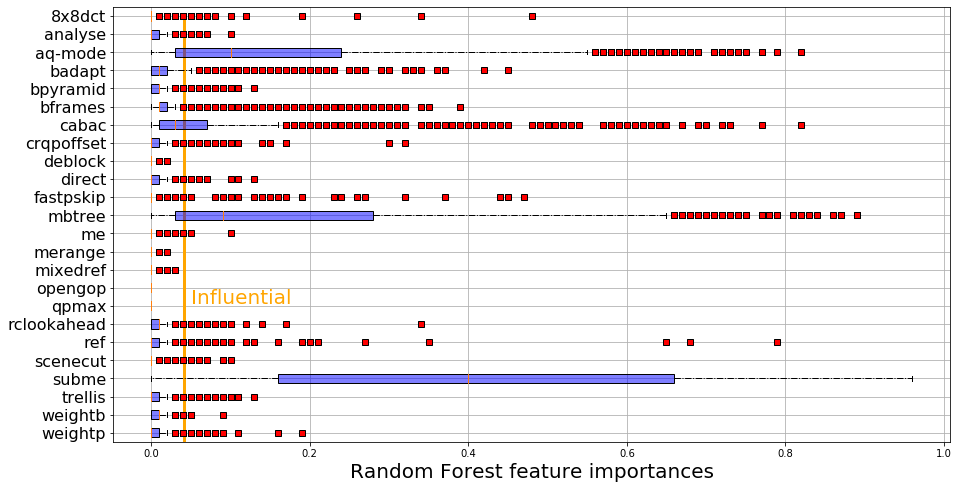

In [28]:
# we sort the features by names 
# here the first columns is not used, but it is useful 
# if we want to put the important features on top of the graph
listImp = [(np.abs(np.percentile(res_imp[col],75)-np.percentile(res_imp[col],25)),res_imp[col], col) 
           for col in res_imp.columns]
listImp.sort(key=lambda tup: tup[2], reverse=True)

# the names of the features
names = [l[2] for l in listImp]

# pretty names, we replace the names
to_replace_b4 = ["b_adapt", "b_pyramid", "chroma_qp_offset", "fast_pskip", 
                 "me_range", "mixed_ref", "open_gop", "rc_lookahead"]
to_replace_after = ["badapt", "bpyramid", "crqpoffset", "fastpskip", 
                    "merange", "mixedref", "opengop", "rclookahead"]

for n in range(len(to_replace_b4)):
    names[np.where(np.array(names, str) == to_replace_b4[n])[0][0]] = to_replace_after[n]

# fancy boxplot
red_square = dict(markerfacecolor='r', marker='s')
plt.figure(figsize=(15,8))
plt.grid()
plt.boxplot([l[1] for l in listImp], flierprops=red_square, 
          vert=False, patch_artist=True, #widths=0.25,
          boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
          whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
# we add a line separating the influential features (median on the right of the orange line)
# from the rest of the features
plt.vlines(x = float(1/24), ymin = 0.5, ymax = 24, color="orange", linewidth=3)
plt.text(s = "Influential", x = 0.05, y = 8.1, size = 20, color = 'orange')
plt.xlabel("Random Forest feature importances", size=20)
plt.yticks(range(1, len(listImp) + 1), names, size= 16)
plt.savefig("../../results/boxplot_features_imp_rf_"+predDimension+".png")
plt.show()

#### B-] Since feature importances do not get how the predicting variables (i.e. the configuraiton options) affect the variable to predict (i.e. the bitrate), we add linear regression coefficients

In [29]:
# alternatively, we can only select the important features to plot the tukey diagrams
short_features = ["mbtree", "aq-mode", "subme"]

# another function to compute the linear regression coefficients (reused for each group)
def compute_poly(listVid, id_short=None):
    # input : a list of videos, (list of ids)
    # output : a dataframe of feature importances
    
    # see compute_importances function, same principle
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
    
    # see compute_importances function, same principle
    listImportances = []
    
    to_keep = [k for k in listFeatures]
    to_keep.append(predDimension)
    
    # this part of the code is not used there, 
    # but allows to add features interactions in the model
    names = listFeatures
    final_names = []
    final_names.append('constant')
    for n in names:
        final_names.append(n)
    for n1 in range(len(names)):
        for n2 in range(len(names)):
            if n1>=n2:
                final_names.append(str(names[n1])+'*'+str(names[n2]))
    
    for id_video in range(len(listVid)):
        # see compute_importances function, same principle
        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        df['deblock'] =[int(val[0]) for val in df['deblock']]
        # see compute_importances function, same principle
        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        # This time, we train an ordinary least square regression
        # i.e. we fit weights to predicting variables so it minimizes
        # the mean squared error between the prediction and the measures of bitrates 
        clf = LinearRegression()
        X = df.drop([predDimension],axis=1)
        #X = df[short_features]

        y = df[predDimension]
        # this part of the code is not used there, 
        # but allows to add features interactions in the model
        #poly = PolynomialFeatures(degree=1, interaction_only = False, include_bias = True)    
        #X_interact = pd.DataFrame(poly.fit_transform(X))#, columns=final_names)
        #kept_names = ['subme','aq-mode','mbtree','cabac','cabac*mbtree','aq-mode*subme','cabac*subme']
        
        # we train the model
        clf.fit(X,y)
        listImportances.append(clf.coef_)

    #res = pd.DataFrame({'features' : short_features})
    res = pd.DataFrame({'features' : listFeatures})

    # see compute_importances function, same principle
    cs = 100
    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = np.round(cs*listImportances[id_video])/cs
    
    # see compute_importances function, same principle
    res = res.set_index('features').transpose()#.drop(['open_gop','qpmax'])
    #res = res.set_index('features').drop(['open_gop','qpmax']).transpose()
    return res

# we compute the coefficients
res_coef = compute_poly(listVideo)
# we can save the coefficients, useful for an analysis input per input
#res_coef.to_csv("../../results/list_features_importances_poly_"+predDimension+".csv")
# and we print them
res_coef

features,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,8x8dct,...,b_adapt,direct,weightb,open_gop,weightp,scenecut,rc_lookahead,mbtree,qpmax,aq-mode
video_0,-0.18,-0.00,0.06,-0.07,-0.07,-0.03,-0.03,-0.06,-0.09,-0.01,...,0.05,-0.02,-0.18,0.0,-0.13,-0.15,-0.01,-0.05,0.0,0.00
video_1,-0.25,-0.15,-0.04,-0.04,-0.17,-0.28,0.00,-0.04,0.04,-0.19,...,0.04,-0.01,-0.14,0.0,-0.06,0.03,-0.01,0.13,0.0,-0.43
video_2,-0.19,0.00,-0.05,-0.03,-0.07,-0.30,-0.05,-0.03,0.03,-0.11,...,0.06,-0.02,-0.34,0.0,0.04,-0.04,0.05,-0.02,0.0,-0.27
video_3,-0.15,0.07,-0.09,-0.04,-0.06,-0.32,-0.01,-0.05,0.11,-0.17,...,0.12,-0.01,-0.33,0.0,0.03,-0.01,0.05,0.27,0.0,-0.43
video_4,-0.14,0.02,-0.05,-0.00,-0.10,-0.26,-0.01,-0.04,0.06,-0.20,...,0.13,-0.04,-0.33,0.0,0.01,0.01,0.03,0.11,0.0,-0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
video_1392,-0.16,0.05,-0.09,-0.05,-0.06,-0.33,-0.01,-0.06,0.05,-0.20,...,0.19,-0.02,-0.36,0.0,0.06,-0.04,0.11,-0.13,0.0,-0.29
video_1393,-0.06,0.11,-0.13,-0.08,-0.05,-0.37,-0.02,-0.06,0.11,-0.21,...,0.08,-0.00,-0.33,0.0,0.03,0.00,0.06,0.42,0.0,-0.47
video_1394,-0.14,0.07,-0.12,-0.06,-0.06,-0.41,-0.01,-0.06,0.10,-0.21,...,0.16,0.00,-0.31,0.0,0.02,0.00,0.05,0.09,0.0,-0.35
video_1395,-0.44,0.01,-0.07,-0.05,-0.10,-0.12,-0.00,-0.02,0.10,-0.04,...,-0.06,0.02,0.03,0.0,0.03,0.17,0.05,-0.79,0.0,0.46


## Figure 2b
#### Same idea for this plot, see the last cell of RQ1.2-A-]

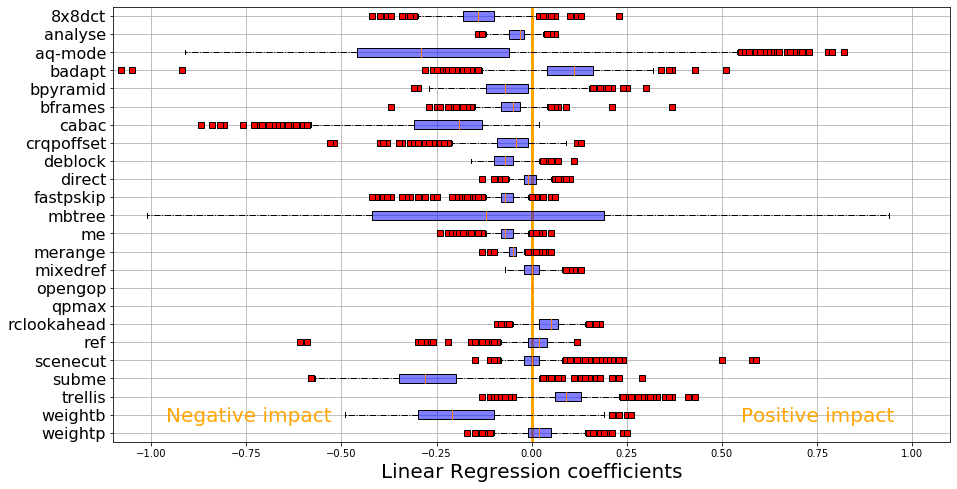

In [30]:
listImp = [(np.abs(np.percentile(res_coef[col],75)-np.percentile(res_coef[col],25)),res_coef[col], col) 
           for col in res_coef.columns]
listImp.sort(key=lambda tup: tup[2], reverse=True)

names = [l[2] for l in listImp]

to_replace_b4 = ["b_adapt", "b_pyramid", "chroma_qp_offset", "fast_pskip", 
                 "me_range", "mixed_ref", "open_gop", "rc_lookahead"]
to_replace_after = ["badapt", "bpyramid", "crqpoffset", "fastpskip", 
                    "merange", "mixedref", "opengop", "rclookahead"]

for n in range(len(to_replace_b4)):
    names[np.where(np.array(names, str) == to_replace_b4[n])[0][0]] = to_replace_after[n]
    
red_square = dict(markerfacecolor='r', marker='s')
plt.figure(figsize=(15,8))
plt.grid()
plt.boxplot([l[1] for l in listImp], flierprops=red_square, 
          vert=False, patch_artist=True, #widths=0.25,
          boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
          whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
# A feature will have a positive impact on the bitrate associated to a video if his coefficient is positive
# A feature will have a negative impact on the bitrate associated to a video if his coefficient is negative
# The border or limit between these two ranges is the vertical line at x = 0
plt.vlines(x = 0, ymin = 0.5, ymax = 24.5, color="orange", linewidth= 3)
plt.text(s = "Negative impact", x = -0.96, y = 1.6, size = 20, color = 'orange')
plt.text(s = "Positive impact", x = 0.55, y = 1.6, size = 20, color = 'orange')
plt.xlabel("Linear Regression coefficients", size = 20)
plt.yticks(range(1, len(listImp) + 1), names, size= 16)
plt.xlim(-1.1, 1.1)
plt.savefig("../../results/boxplot_features_imp_linear_"+predDimension+".png")
plt.show()

# In the paper, here starts Section III

## RQ1bis - Can we group together videos having same performance distributions?

#### We use figure 1 groups to isolate encoding profile of input videos associated to bitrate

### We load the metrics of the youtube UGC dataset, needed for RQ2

In [31]:
# we load the file (in itself an aggregation of datasets)
# the file is available in the data folder, then ugc_meta
# each line is a video, and the columns are the different metrics
# provided by Wang et. al.
meta = pd.read_csv("../../data/ugc/ugc_meta/all_features.csv").set_index('FILENAME')
# category is a high-level characterization of the content of the video
# for an example, Sports for a sports video
# you can see more details about different categories 
# and metrics per category in the resources/categories.csv file
# I also recommand to read the Youtube UGC paper to understand why we consider these categories
meta['category']=[str(meta.index[i]).split('_')[0] for i in range(meta.shape[0])]
# a lot of NA, not a big feature importance, seems complicated to compute -> remove NOISE DMOS
del meta['NOISE_DMOS']
# fill NA with zeros
meta = meta.fillna(0)
# create a numeric variable (quanti) to compute the category
# one video has one and only one category (1 to 1 in sql, so we can join the tables)
# again, to do it properly, we should use dummies
# but then we cannot compare directly the importances of the metrics to categories 
cat_tab = pd.Series(meta['category'].values).unique()
meta['video_category'] = [np.where(cat_tab==meta['category'][i])[0][0] for i in range(len(meta['category']))]
# delete the old columns (quali)
del meta['category']
# we normalize the variables, since height mean is about 1000, and complexity about 2
# different scales do not behave correctly with learning algorithms
for col in meta.columns:#[:len(meta.columns)-1]:
    inter = np.array(meta[col],float)
    meta[col] = (inter-np.mean(inter))/np.std(inter)
# left join performance groups to the dataset of metrics
perf = pd.DataFrame({'FILENAME': np.array([v_names[k][:-4] for k in range(len(v_names))]),
              'perf_group' : np.array([k for k in groups])}).set_index('FILENAME')
meta_perf = perf.join(meta)
# print the results
meta_perf

,perf_group,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category
FILENAME,,,,,,,,,,
Animation_1080P-01b3,2,-0.678859,4.653015,0.383054,0.332504,-1.475487,-1.547345,-0.892454,-1.210798,-1.618194
Animation_1080P-05f8,0,0.844509,0.741729,0.383054,0.332504,-0.147257,0.444086,2.545710,2.207516,-1.618194
Animation_1080P-0c4f,3,-0.655778,-0.377464,0.383054,0.332504,0.422320,-0.963192,1.054868,-1.232460,-1.618194
Animation_1080P-0cdf,0,-0.294170,-0.059377,0.383054,0.332504,-0.028644,0.430810,-0.103261,-0.448284,-1.618194
Animation_1080P-18f5,0,-0.478821,-0.377464,0.383054,0.332504,1.289017,-0.958767,-0.051295,0.192920,-1.618194
...,...,...,...,...,...,...,...,...,...,...
Vlog_720P-561e,3,-0.678859,-0.377464,-0.239786,-0.333314,0.978979,-1.414583,-0.652893,0.457201,1.494379
Vlog_720P-5d08,0,-0.678859,-0.377464,-0.773092,-0.333314,3.257287,-0.303807,-0.437698,-0.158009,1.494379
Vlog_720P-60f8,0,0.444433,0.623920,-0.239786,-0.333314,0.234418,-0.042708,-0.364385,-0.149344,1.494379


#### We compute the count of categories per group

In [32]:
# keep str categories, to detect which categories are more represented per performance group
meta_perf['str_video_cat'] = [str(meta_perf.index[i]).split('_')[0] for i in range(meta_perf.shape[0])]
# count the occurence
total_cat = meta_perf.groupby('str_video_cat').count()['perf_group']
# performance group per input id
group_perf = np.array([gr for gr in groups])
group_perf

array([2, 0, 3, ..., 0, 1, 3])

#### We define a function to depict a boxplot

In [33]:
def boxplot_imp(res, xlim = None, criteria = 'max', name = None, xname='Feature importances'):
    # sort features by decreasing Q3 (max up, min down)
    if criteria == 'max':
        listImp = [(np.percentile(res[col],75), res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[0])
    # sort features by decreasing Inter Quartile Range (max up, min down)
    elif criteria == 'range':
        listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[0])
    # sort features by names, (A up, Z down)
    elif criteria == 'name':
        listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[2], reverse=True)
    
    # see figures 2a and 2b
    red_square = dict(markerfacecolor='r', marker='s')
    plt.figure(figsize=(15,8))
    plt.grid()
    plt.boxplot([l[1] for l in listImp], flierprops=red_square, 
              vert=False, patch_artist=True, #widths=0.25,
              boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
              whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
    plt.xlabel(xname, size=13)
    if xlim:
        plt.xlim(xlim)
    plt.yticks(range(1, len(listImp) + 1), [l[2] for l in listImp])
    if name:
        plt.savefig(name)
    plt.show()

In [34]:
input_sizes = pd.read_csv("../../data/ugc/ugc_meta/sizes.csv", delimiter=',').set_index('name')

## Figure 4

#### Summary for each group

#### The idea of this part is to show that groups of performance are homogeneous; in a group, the inputs have a lot in common
#### Ok, same bitrates, but that's just the obvious part !!! 
#### Other raw performances, feature importances, linear reg coefficients, they are 
#### These groups are semantically valids and extend the classification of 2004, established by Maxiaguine et al.

Interestingly, groups formed by encoded sizes (with respect to the same protocol gives the same groups, except for 30 videos (going from the fourth to the third group)

In [35]:
# [begin what if] they should be already defined, to remove?
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", 
                "trellis", "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", 
                "b_adapt", "direct", "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", 
                "mbtree", "qpmax", "aq-mode"]

to_keep = [k for k in listFeatures]
to_keep.append(predDimension)

categorial = ['analyse', 'me', 'direct']
# [end what if]

# computes a summary 
def summary_group(id_group):
    # input : A group id, see Figure 1 of the paper, from 0 to 3 (1 to 4 in the paper)
    # output: in the console (not optimized yet to output directly the table)
    
    # first, we isolate all the ids of one group
    id_list = [i for i in range(len(listVideo)) if group_perf[i]==id_group]
    v_names_group = [v_names[i][:-4] for i in range(len(v_names)) if i in id_list]
    listVideoGroup = [listVideo[i] for i in range(len(listVideo)) if i in id_list]
    
    # print the ids, plus the number of videos
    print('Group '+str(id_group)+' : '+str(len(listVideoGroup))+' videos!')
    
    print('\n')
    
    # average sizes of videos (Warning : BEFORE COMPRESSION!) per group
    video_size = [input_sizes.loc[index_vid]['size'] for index_vid in v_names_group]
    
    # mean and stds
    print("input avg size :", np.mean(video_size))
    print("input std size :", np.std(video_size))
    
    print('\n')

    # features importances per groupfor influential features
    res_imp = compute_Importances(listVideoGroup)
    
    print('\n')
    
    # for mbtree
    print('Imp mbtree:', np.mean(res_imp['mbtree']))
    print('Imp std mbtree:', np.std(res_imp['mbtree']))
    
    # for aq-mode
    print('Imp aq-mode:', np.mean(res_imp['aq-mode']))
    print('Imp std aq-mode:', np.std(res_imp['aq-mode']))
    
    # for subme
    print('Imp subme:', np.mean(res_imp['subme']))
    print('Imp std subme:', np.std(res_imp['subme']))
    
    # see the previous cell, boxplot of feature importances per group
    boxplot_imp(res_imp, criteria = 'name', xlim= (0, 1),
               name ="../../results/boxplot_imp_group"+str(id_group)+".png")

    # features effects
    res_poly = compute_poly(listVideoGroup)
    
    print('\n')
    
    # mean and stds for influential features, same as with rf feature importances
    print('Coef mbtree:', np.mean(res_poly['mbtree']))
    print('Coef mbtree std :', np.std(res_poly['mbtree']))
    print('Coef aq-mode:', np.mean(res_poly['aq-mode']))
    print('Coef aq_mode std :', np.std(res_poly['aq-mode']))
    print('Coef subme:', np.mean(res_poly['subme']))
    print('Coef subme std:', np.std(res_poly['subme']))
    
    # Boxplot of linear coefficients
    boxplot_imp(res_poly, criteria = 'name', xlim = (-1, 1),
               name ="../../results/boxplot_effect_group"+str(id_group)+".png", xname = 'Coefficients')

    print('\n')
    
    # The five performances we measured during this experience
    interest_var = ['cpu', 'etime', 'fps', 'kbs', 'size']
    
    # mean and stds
    for iv in interest_var:
        pred = [np.mean(lv[iv]) for lv in listVideoGroup]
        print('Mean '+iv+' in the group: '+str(np.round(np.mean(pred),1)))
        print('Std dev : '+iv+' in the group: '+str(np.round(np.std(pred),1)))

    print('\n')

    # percentage of the videos present in the group per category
    meta_perf_group = meta_perf.query('perf_group=='+str(id_group))
    meta_perf_group['str_video_cat'] = [str(meta_perf_group.index[i]).split('_')[0] for i in range(meta_perf_group.shape[0])]
    val_group = meta_perf_group.groupby('str_video_cat').count()['perf_group']
    df_res_cat_group = pd.DataFrame({'val': val_group, 'total': total_cat})
    print(df_res_cat_group['val']/df_res_cat_group['total'])

    print('\n')

    # Mean of the videos of the group per properties
    for col in meta_perf_group.columns:
        if col not in ['str_video_cat', 'video_category']:
            print('Mean '+col+' : '+str(meta_perf_group[col].mean()))
            print('std '+col+' : '+str(meta_perf_group[col].std()))

    print('\n')
    
    # Spearman Correlations intra-groups
    corrGroup = np.array([corrSpearman[i][j] for i in range(len(corrSpearman)) if i in id_list 
                 for j in range(len(corrSpearman)) if j in id_list],float)

    print("Correlations intra-group: \n" + str(pd.Series(corrGroup).describe())+'\n')

Group 0 : 470 videos!


input avg size : 1637205973.9170213
input std size : 2438557837.558484




Imp mbtree: 0.09019148936170213
Imp std mbtree: 0.09448722491559315
Imp aq-mode: 0.27551063829787237
Imp std aq-mode: 0.1938382054364583
Imp subme: 0.48546808510638295
Imp std subme: 0.24501778928589235


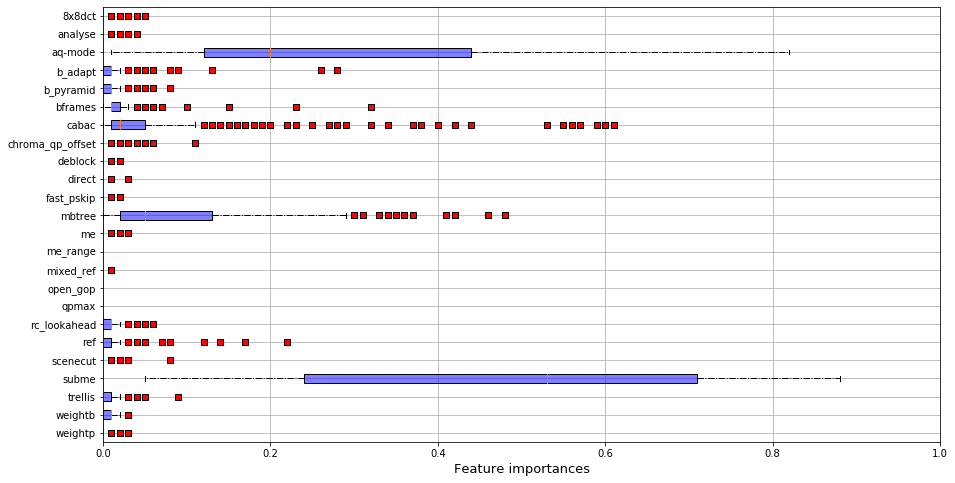



Coef mbtree: 0.33312765957446805
Coef mbtree std : 0.19396699840176548
Coef aq-mode: -0.5040851063829788
Coef aq_mode std : 0.13980804922909124
Coef subme: -0.3180851063829787
Coef subme std: 0.09194212559556819


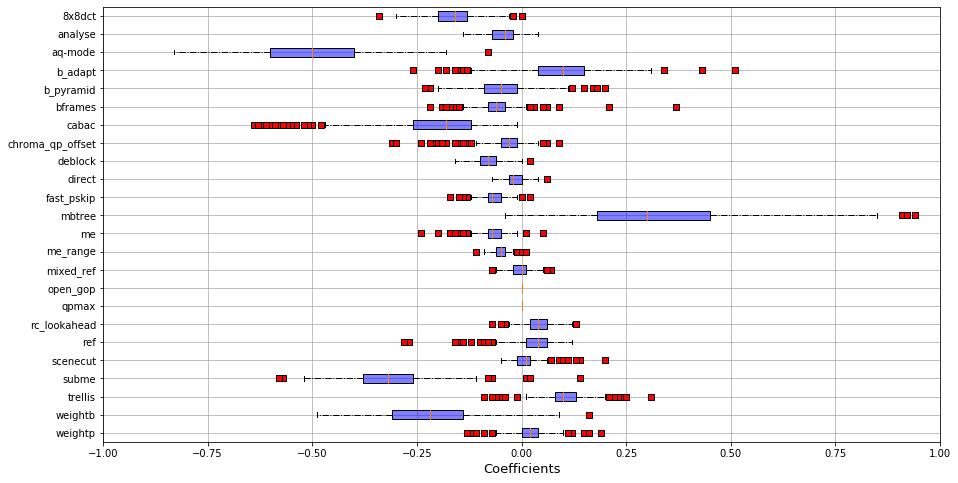



Mean cpu in the group: 1074.5
Std dev : cpu in the group: 398.9
Mean etime in the group: 8.9
Std dev : etime in the group: 10.7
Mean fps in the group: 389.4
Std dev : fps in the group: 302.9
Mean kbs in the group: 15015.6
Std dev : kbs in the group: 19927.0
Mean size in the group: 37383809.7
Std dev : size in the group: 49629655.1


str_video_cat
Animation         0.252874
CoverSong         0.277108
Gaming            0.363636
HDR               0.057692
HowTo             0.252874
Lecture           0.086538
LiveMusic         0.324324
LyricVideo        0.216667
MusicVideo        0.282051
NewsClip          0.489583
Sports            0.567742
TelevisionClip    0.254545
VR                0.426966
VerticalVideo     0.289474
Vlog              0.449367
dtype: float64


Mean perf_group : 0.0
std perf_group : 0.0
Mean SLEEQ_DMOS : -0.029323948203180957
std SLEEQ_DMOS : 0.9164326353194944
Mean BANDING_DMOS : -0.1830523651266118
std BANDING_DMOS : 0.5248708286866567
Mean WIDTH : -0.06749438276653

/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
count    220900.000000
mean          0.817473
std           0.106043
min           0.150032
25%           0.758338
50%           0.837353
75%           0.897179
max           1.000000
dtype: float64



In [36]:
summary_group(0)

Group 1 : 219 videos!


input avg size : 4415585852.876713
input std size : 7212521059.6005535




Imp mbtree: 0.47360730593607303
Imp std mbtree: 0.19580591252669888
Imp aq-mode: 0.1341095890410959
Imp std aq-mode: 0.12764286238959544
Imp subme: 0.144703196347032
Imp std subme: 0.14399479486664607


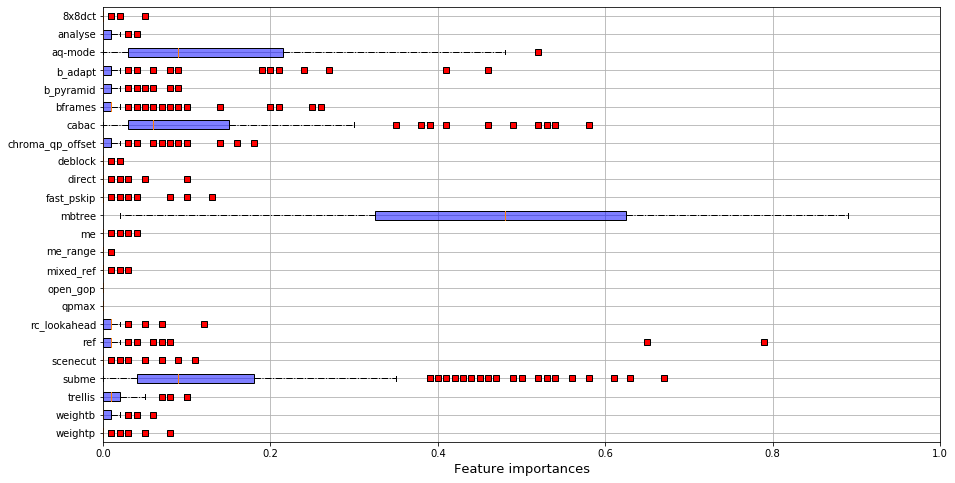



Coef mbtree: -0.6810958904109589
Coef mbtree std : 0.18010824987381613
Coef aq-mode: 0.3553881278538813
Coef aq_mode std : 0.20988844622573236
Coef subme: -0.16114155251141554
Coef subme std: 0.12383916900657123


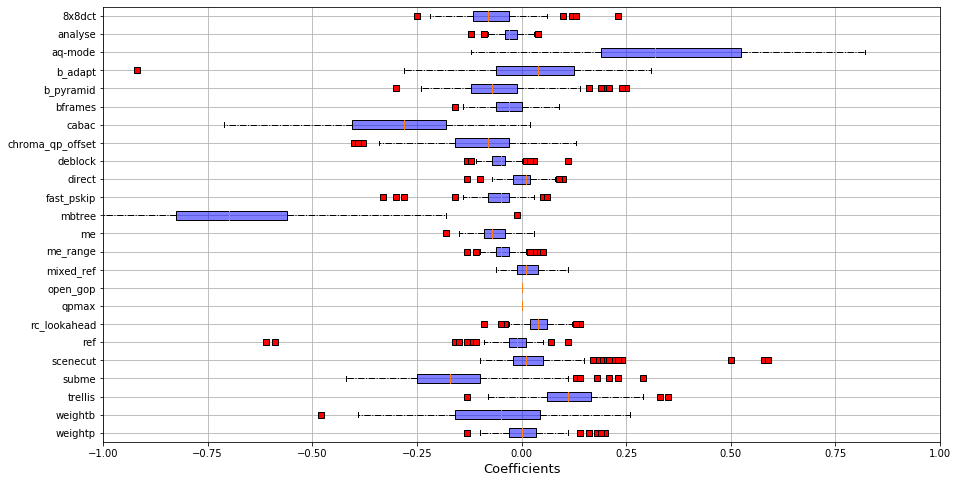



Mean cpu in the group: 1029.7
Std dev : cpu in the group: 377.2
Mean etime in the group: 19.1
Std dev : etime in the group: 30.4
Mean fps in the group: 244.2
Std dev : fps in the group: 256.7
Mean kbs in the group: 9223.9
Std dev : kbs in the group: 11328.4
Mean size in the group: 22805170.5
Std dev : size in the group: 28350618.9


str_video_cat
Animation         0.126437
CoverSong         0.216867
Gaming            0.139860
HDR               0.519231
HowTo             0.103448
Lecture           0.240385
LiveMusic         0.135135
LyricVideo        0.183333
MusicVideo        0.153846
NewsClip          0.062500
Sports            0.064516
TelevisionClip    0.072727
VR                0.089888
VerticalVideo     0.197368
Vlog              0.208861
dtype: float64


Mean perf_group : 1.0
std perf_group : 0.0
Mean SLEEQ_DMOS : 0.005360393998249836
std SLEEQ_DMOS : 0.8958933053763064
Mean BANDING_DMOS : 0.1688188082623658
std BANDING_DMOS : 1.20468743040557
Mean WIDTH : 0.521797505328845
std

/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
count    47961.000000
mean         0.792342
std          0.139192
min         -0.070206
25%          0.727803
50%          0.824210
75%          0.891503
max          1.000000
dtype: float64



In [37]:
summary_group(1)

Group 2 : 292 videos!


input avg size : 2092791930.6780822
input std size : 3964394793.670366




Imp mbtree: 0.34243150684931506
Imp std mbtree: 0.22422143554531843
Imp aq-mode: 0.045239726027397266
Imp std aq-mode: 0.07295812317289446
Imp subme: 0.3575684931506849
Imp std subme: 0.24423751654234144


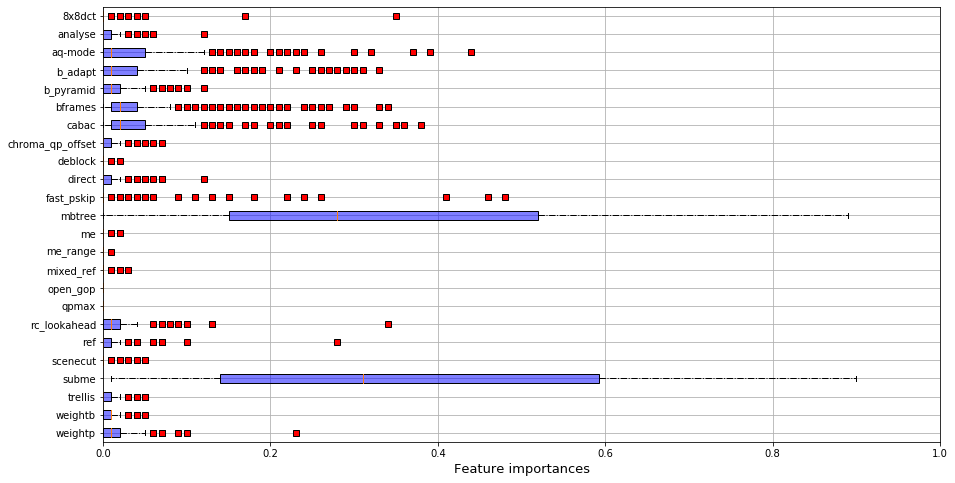



Coef mbtree: -0.41743150684931507
Coef mbtree std : 0.14839983973029075
Coef aq-mode: -0.1354109589041096
Coef aq_mode std : 0.13883135878205718
Coef subme: -0.23380136986301372
Coef subme std: 0.10317694070873534


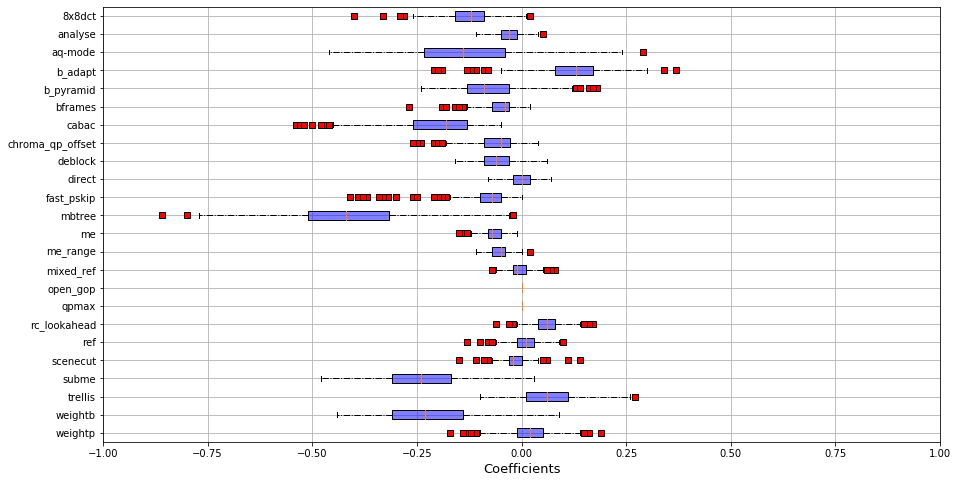



Mean cpu in the group: 813.9
Std dev : cpu in the group: 345.9
Mean etime in the group: 8.4
Std dev : etime in the group: 16.5
Mean fps in the group: 546.0
Std dev : fps in the group: 434.1
Mean kbs in the group: 4882.3
Std dev : kbs in the group: 9150.7
Mean size in the group: 12024467.4
Std dev : size in the group: 22828024.5


str_video_cat
Animation         0.321839
CoverSong         0.325301
Gaming            0.132867
HDR               0.211538
HowTo             0.356322
Lecture           0.375000
LiveMusic         0.148649
LyricVideo        0.300000
MusicVideo        0.192308
NewsClip          0.114583
Sports            0.109677
TelevisionClip    0.381818
VR                0.179775
VerticalVideo     0.171053
Vlog              0.094937
dtype: float64


Mean perf_group : 2.0
std perf_group : 0.0
Mean SLEEQ_DMOS : -0.01814251799112101
std SLEEQ_DMOS : 1.1494241899350455
Mean BANDING_DMOS : 0.25552197476787375
std BANDING_DMOS : 1.4454605442030628
Mean WIDTH : -0.07598371613632829


/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
count    85264.000000
mean         0.854160
std          0.087861
min          0.388941
25%          0.806319
50%          0.870667
75%          0.920543
max          1.000000
dtype: float64



In [38]:
summary_group(2)

Group 3 : 416 videos!


input avg size : 1930201013.7163463
input std size : 4601483233.336385




Imp mbtree: 0.05466346153846154
Imp std mbtree: 0.06788623268393786
Imp aq-mode: 0.1535576923076923
Imp std aq-mode: 0.18341796672559502
Imp subme: 0.5147596153846153
Imp std subme: 0.2424622093945105


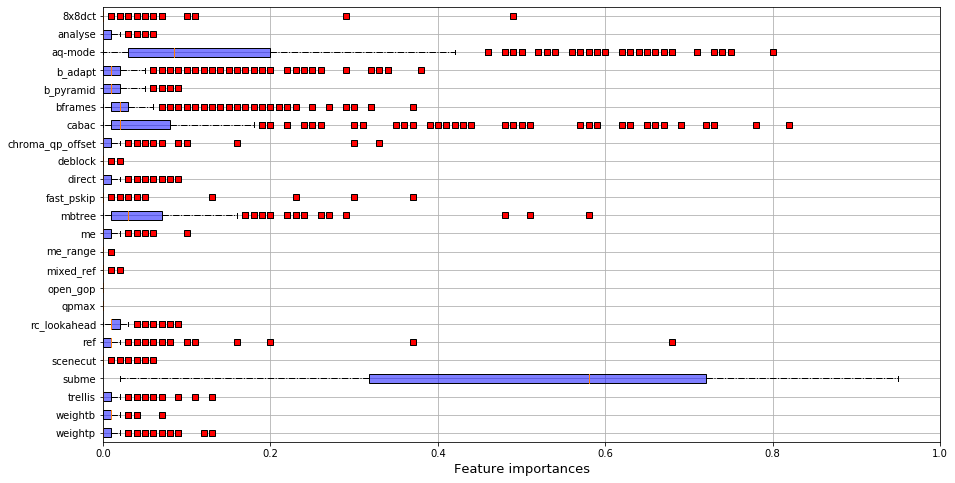



Coef mbtree: -0.1120673076923077
Coef mbtree std : 0.14862528801958744
Coef aq-mode: -0.28807692307692306
Coef aq_mode std : 0.1810244720126415
Coef subme: -0.28870192307692305
Coef subme std: 0.1088345056114392


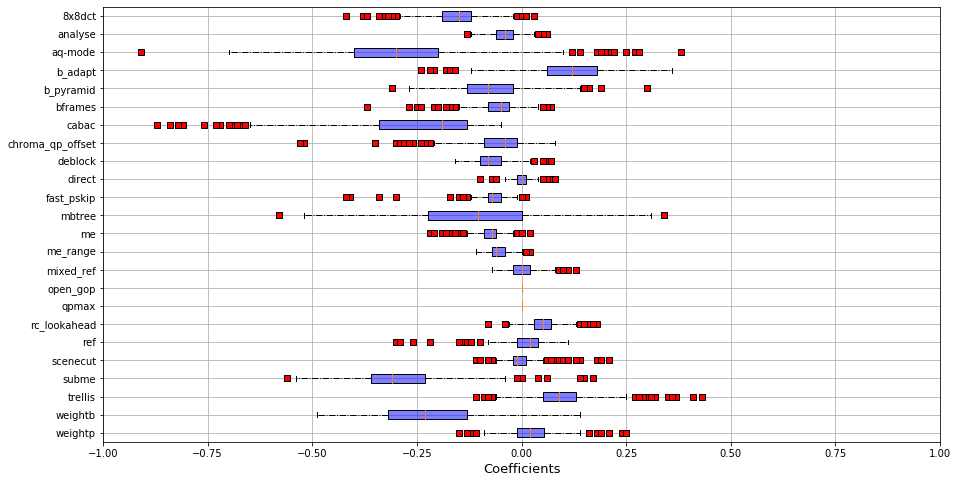



Mean cpu in the group: 912.9
Std dev : cpu in the group: 354.9
Mean etime in the group: 8.9
Std dev : etime in the group: 19.8
Mean fps in the group: 480.0
Std dev : fps in the group: 361.5
Mean kbs in the group: 7462.7
Std dev : kbs in the group: 11611.8
Mean size in the group: 18439974.0
Std dev : size in the group: 28795627.9


str_video_cat
Animation         0.298851
CoverSong         0.180723
Gaming            0.363636
HDR               0.211538
HowTo             0.287356
Lecture           0.298077
LiveMusic         0.391892
LyricVideo        0.300000
MusicVideo        0.371795
NewsClip          0.333333
Sports            0.258065
TelevisionClip    0.290909
VR                0.303371
VerticalVideo     0.342105
Vlog              0.246835
dtype: float64


Mean perf_group : 3.0
std perf_group : 0.0
Mean SLEEQ_DMOS : 0.04304313611366742
std SLEEQ_DMOS : 1.0324835249359274
Mean BANDING_DMOS : -0.06141616353886917
std BANDING_DMOS : 0.851350507488393
Mean WIDTH : -0.1451058861897496
s

/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
count    173056.000000
mean          0.733806
std           0.172576
min          -0.157557
25%           0.633778
50%           0.773363
75%           0.867401
max           1.000000
dtype: float64



In [39]:
summary_group(3)

### Inter-group correlogram

In [40]:
group_perf =groups
id_list_0 = [i for i in range(len(listVideo)) if group_perf[i]==1]
id_list_1 = [i for i in range(len(listVideo)) if group_perf[i]==3]
id_list_2 = [i for i in range(len(listVideo)) if group_perf[i]==0]
id_list_3 = [i for i in range(len(listVideo)) if group_perf[i]==2]

res = np.zeros(16).reshape(4,4)
stds = np.zeros(16).reshape(4,4)
res_med = np.zeros(16).reshape(4,4)

tab = []
for id0 in id_list_0:
    for id1 in id_list_1:
        tab.append(corrSpearman[id0][id1])
res[0][1] = np.mean(tab)
stds[0][1] = np.std(tab)
res_med[0][1] = np.median(tab)

tab = []
for id0 in id_list_0:
    for id2 in id_list_2:
        tab.append(corrSpearman[id0][id2])
res[0][2] = np.mean(tab)
stds[0][2] = np.std(tab)
res_med[0][2] = np.median(tab)

tab = []
for id0 in id_list_0:
    for id3 in id_list_3:
        tab.append(corrSpearman[id0][id3])
res[0][3] = np.mean(tab)
stds[0][3] = np.std(tab)
res_med[0][3] = np.median(tab)

tab = []
for id1 in id_list_1:
    for id2 in id_list_2:
        tab.append(corrSpearman[id1][id2])
res[1][2] = np.mean(tab)
stds[1][2] = np.std(tab)
res_med[1][2] = np.median(tab)

tab = []
for id1 in id_list_1:
    for id3 in id_list_3:
        tab.append(corrSpearman[id1][id3])
res[1][3] = np.mean(tab)
stds[1][3] = np.std(tab)
res_med[1][3] = np.median(tab)

tab = []
for id2 in id_list_2:
    for id3 in id_list_3:
        tab.append(corrSpearman[id2][id3])
res[2][3] = np.mean(tab)
stds[2][3] = np.std(tab)
res_med[2][3] = np.median(tab)


res[0][0] = np.mean([[corrSpearman[id1][id2] for id1 in id_list_0] for id2 in id_list_0])
res[1][1] = np.mean([[corrSpearman[id1][id2] for id1 in id_list_1] for id2 in id_list_1])
res[2][2] = np.mean([[corrSpearman[id1][id2] for id1 in id_list_2] for id2 in id_list_2])
res[3][3] = np.mean([[corrSpearman[id1][id2] for id1 in id_list_3] for id2 in id_list_3])

print("AVG")
print(res)
print("STD")
print(stds)
print('MEDIAN')
print(res_med)

AVG
[[0.7923419  0.45023686 0.0414419  0.67379695]
 [0.         0.73380599 0.59842234 0.71700603]
 [0.         0.         0.81747322 0.37538304]
 [0.         0.         0.         0.85416018]]
STD
[[0.         0.20491938 0.21617771 0.17425259]
 [0.         0.         0.17676751 0.15529403]
 [0.         0.         0.         0.18792134]
 [0.         0.         0.         0.        ]]
MEDIAN
[[0.         0.47675224 0.04817805 0.71022817]
 [0.         0.         0.61590102 0.74202928]
 [0.         0.         0.         0.38420647]
 [0.         0.         0.         0.        ]]


#### In a group (correlation intra), the performances are highly or very highly correlated

#### Between the different (correlaiton inter), the performances of inputs are generally moderate or low (except for groups 3 and 4)

## INTUITION of Inputec : why should we use the metrics of the youtube UGC Dataset to discriminate the videos into groups?

Due to the lack of space, we didn't explain this experiment in the paper; but we still think it is an important milestone to understand how we've got the idea of Inputec!

### We used the metrics of Youtube UGC to classify each video in its performance group.

### RESULTS : in average, we classify successfully two videos over three (~66%) in the right performance group

In [41]:
if 'str_video_cat' in meta_perf.columns:
    del meta_perf['str_video_cat']

accuracy = []

nbLaunches = 10
for i in range(nbLaunches):
    X = np.array(meta_perf[[k for k in meta_perf.columns if k !='perf_group']], float)
    y = np.array(meta_perf['perf_group'], float)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)


    conf = pd.crosstab(y_pred, y_test)#, colnames=[1,2,3], rownames=[1,2,3])
    val = np.sum(np.diag(conf))/len(y_test)
    accuracy.append(val)
    print('Test accuracy : '+ str(val))
    conf.columns = pd.Int64Index([1,2,3,4], dtype='int64', name='Observed')
    conf.index = pd.Int64Index([1,2,3,4], dtype='int64', name='Predicted')
    conf
print(np.mean(accuracy))
conf

Test accuracy : 0.6857142857142857
Test accuracy : 0.6595238095238095
Test accuracy : 0.638095238095238
Test accuracy : 0.6785714285714286
Test accuracy : 0.6880952380952381
Test accuracy : 0.65
Test accuracy : 0.6619047619047619
Test accuracy : 0.6642857142857143
Test accuracy : 0.6785714285714286
Test accuracy : 0.6595238095238095
0.6664285714285716


Observed,1,2,3,4
Predicted,,,,
1,118,1,3,29
2,0,33,11,10
3,1,21,48,17
4,20,7,23,78


# In the paper, here starts Section IV

# RQ2 - Can we use Inputec to find configurations adapted to input videos?

### The goal fixed in RQ2 is to generate a configuration minimizing the bitrate for a given video!

In [42]:
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", 
                "b_adapt", "direct", "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", 
                "mbtree", "qpmax", "aq-mode"]
categorial = ['analyse', 'me', 'direct']
val_config = listVideo[0][listFeatures].replace(to_replace ="None",value='0')
val_config['deblock'] =[int(val[0]) for val in val_config['deblock']]

for col in val_config.columns:
    if col not in categorial:
        arr_col = np.array(val_config[col],int)
        arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
        val_config[col] = arr_col
    else:
        if col not in [predDimension,'ranking']:
            val_config[col] = [np.where(k==val_config[col].unique())[0][0] for k in val_config[col]]
            arr_col = np.array(val_config[col],int)
            arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
            val_config[col] = arr_col

#### Function to "place" a value (i.e. give a rank to a value) in an ordered list

In [43]:
def find_rank(sorted_perfs, val):
    # inputs : a list of sorted performances, a value 
    # output: the ranking of value in the sorted_perf list 
    rank = 0
    while val > sorted_perfs[rank] and rank < len(sorted_perfs)-1:
        rank+=1
    return rank

## Method M1 - Inputec, full configurations, full properties

## [1 sentence explanation] We included the properties in the set of predicting variables

#### [short explanation] Offline: by including the input properties, we discriminate the input videos into performance groups, thus increasing the mean absolute error of the prediction. Online: instead of measuring new configurations (as known as transfer learning), we compute the input properties, and test all the configurations. At the end, we select the one giving the minimal prediction.

## OFFLINE

#### [OFFLINE] Construct the data

Lines 1-12 in Algorithm 1

In [44]:
# we separate the list of videos into a training (i.e. offline) set and a test set (i.e. online)
train_ind, test_ind = train_test_split([k for k in range(len(listVideo))], test_size = 0.25)
# training set indexes
train_index = [v_names[k][:-4] for k in train_ind]

# we add the input properties
name_col = list(meta_perf.columns)[1:]

# we add the x264 configuration options
for vcc in val_config.columns:
    name_col.append(vcc)

# Then, X (i.e the predicting variables) =  input properties + software configuration options

# we add the variable to predict, i.e. y the bitrate performance distribution
name_col.append("bitrate")

# X length, the number of predicting variables
nb_col = len(name_col)
# the number of configurations
nb_config = 201

# generate the datasets = (X,y)
def gen_dataset(inputs_names):
    # inputs : names of videos
    # output : aggregation of multiple (X,y) for all the videos in the list of names provided in input 
    
    # the final dataset
    res = pd.DataFrame(np.zeros(nb_config*len(inputs_names)*nb_col).reshape(nb_config*len(inputs_names), nb_col))
    res.columns = name_col
    
    # we add the data video per video
    # LINES 6-10 in Algorithm 1
    for i in range(len(inputs_names)):
        # first, we retrieve the name of the video
        video_name = inputs_names[i]
        index_video = np.where(np.array([v[:-4] for v in v_names], str)==video_name)[0][0]
        # we compute the performance, here
        bitrates = listVideo[index_video][predDimension]
        # get the input properties of the video
        video_prop = np.array(meta_perf.loc[video_name][1:], float)
        # compute the avrage value and the standard deviation for the bitrate
        # as we said in the paper, it does not change the order of variable
        # which is a good property
        moy = np.mean(bitrates)
        std = np.std(bitrates)
        # for each configuration, we add the values of the input properties and the configuration options (=X)
        # and the normalized values of bitrates (=y)
        for config_id in range(nb_config):
            val = list(tuple(video_prop) + tuple(val_config.loc[config_id]))
            val.append((bitrates[config_id]-moy)/std)
            res.loc[i*nb_config+config_id] = val
    return res

# training dataset
training_data = gen_dataset(train_index)

# dimensions of the different sets = a proxy to the measurement cost 
print("Training size : ", training_data.shape[0])

# OFFLINE - Training data
X_train = np.array(training_data.drop(["bitrate"],axis=1), float)
y_train = np.array(training_data["bitrate"], float)

Training size :  210447


#### [OFFLINE] We train the Learning Algorithm

Lines 13-14 in Algorithm 1

In [45]:
# The hyperparameters were optimized by testing different values for parameters
# and comparing the mean absolute error given by the model
LA = RandomForestRegressor(n_estimators=100, criterion="mse", min_samples_leaf=2, bootstrap=True, 
                           max_depth=None, max_features=15)
# the default config for random forest is quite good
# we train the model LA
LA.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=15, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

## ONLINE

#### [ONLINE] Add new videos

Lines 15-17 in the Algorithm 1

In [46]:
# test set indexes
test_index = [v_names[k][:-4] for k in test_ind]

#### [ONLINE] Predict the value for each configuration, and output the configuration giving the minimal result (i.e. the argmin)

Lines 18-22 in the Algorithm 1

In [47]:
# we compute the time - start
start = time()

# the performance values for the configuration chosen by Inputec, for the test set of videos
inputec = []

# the performance rankings for the configuration chosen by Inputec, for the test set of videos
inputec_ranks = []

# for each video in the test set
for ti in test_index:
    # we retrieve the test index
    index_video = np.where(np.array([v[:-4] for v in v_names], str)==ti)[0][0]
    # list of predictions for inputec
    pred_inputec = []
    # for each configuration
    for i in range(nb_config):
        # we add input properties to the configurations
        video_prop = list(tuple(meta_perf.loc[ti][1:])+tuple(val_config.loc[i]))
        # we predict the value associated to the configuration
        pred_inputec.append(LA.predict(np.array(video_prop, float).reshape(1, 33)))
    # sorted performances
    sorted_perfs = sorted(listVideo[index_video][predDimension])
    # the performance pof the configuration chosen by Inputec
    perf = listVideo[index_video].loc[np.argmin(pred_inputec)][predDimension]
    # we add it to the perf array
    inputec.append(perf)
    # the related ranking (between 0 and 200, hopefully close to 0)
    inputec_ranks.append(find_rank(sorted_perfs, perf))

# we compute the time - end
end = time()

print("Average time for one video prediction < ", int(100*(end-start)/len(test_index))/100, "second(s)!")

Average time for one video prediction <  0.99 second(s)!


## Baselines

To evaluate Inputec, we compare it to different baselines. 
Each baseline corresponds to a concrete situation:

#### B1 - Model reuse

We arbitrarily choose a first video, learn a performance model on it, and select the best configuration minimizing the performance for this video. This baseline represents the error made by a model trained on a  source input (i.e., a  first video) and transposed to a target input (i.e., a second video, different from the first one), without considering the difference of content between the source and the target. In theory, it corresponds to a fixed configuration, optimized for the first video. We add B1 to measure how we can improve the standard performance model with Inputec.

B1 is fixed.

In [55]:
# we arbitraly select an input in the training set
# here we choose on purpose a video for which the model reuse leads to bad results
# to see what could happen when we just reuse the model from one video to another
chosen_input = 423

# we consider the associated input video
source_video = listVideo[np.where(np.array([v[:-4] for v in v_names], str)==
                                  train_index[chosen_input])[0][0]]

# we select the best config for this video
b1_config = np.argmin(source_video[predDimension])

print("Id of B1 configuration :", b1_config)

# the rankings of the first baseline
b1_ranks = []

# for each video in the test set
for ti in test_index:
    # we retrieve the test index of the input video
    index_video = np.where(np.array([v[:-4] for v in v_names], str)==ti)[0][0]
    # sorted performances
    sorted_perfs = sorted(listVideo[index_video][predDimension])
    # the performance of the software configuration of B1
    perf = listVideo[index_video].loc[b1_config][predDimension]
    # we add it to the list
    b1_ranks.append(find_rank(sorted_perfs, perf))

Id of B1 configuration : 161


#### B2 - Best compromise

We select the configuration having the lowest sum of bitrates rankings for the training set of videos, and study this configuration's distribution on the validation set. 
B2 represents the best compromise we can find, working for all input videos. 
In terms of software engineering, it acts like a preset configuration proposed by x264 developers.
Beating this configuration shows that our approach chooses a custom configuration, tailored for the input characteristics.

B2 is fixed.

In [56]:
# only keep the video of the training set (we keep the training-test phases)
keep_vid = ['video'+str(np.where(np.array([v[:-4] for v in v_names], str)==ti)[0][0]) for ti in train_index]

# select the best compromise, i.e. the configuration having the minimal sum of rankings
b2_config = np.argmin([np.sum(np.array(rankings[keep_vid].loc[i], int)) 
                             for i in range(rankings.shape[0])])

print("Id of B2 configuration :", b2_config)

# the rankings of the second baseline
b2_ranks = []

# for each video in the test set
for ti in test_index:
    # we retrieve the test index of the input video
    index_video = np.where(np.array([v[:-4] for v in v_names], str)==ti)[0][0]
    # sorted performances
    sorted_perfs = sorted(listVideo[index_video][predDimension])
    # the performance of the software configuration of B1
    perf = listVideo[index_video].loc[b2_config][predDimension]
    # we add it to the list
    b2_ranks.append(find_rank(sorted_perfs, perf))

Id of B2 configuration : 190


#### B3 - Average performance

This baseline computes the average performance of configurations for each video of the validation dataset. 
It acts as a witness group, reproducing the behavior of a non-expert user that experiments x264 for the first time, and selects uniformly one of the 201 configurations of our dataset.

B3 vary across inputs.

In [57]:
# the average performance values for all configurations, for each input in the test set of videos
b3_perf = []

# the rankings of the third baseline
b3_ranks = []

# for each video in the test set
for ti in test_index:
    # we retrieve the test index
    index_video = np.where(np.array([v[:-4] for v in v_names], str)==ti)[0][0]
    # sorted performances
    sorted_perfs = sorted(listVideo[index_video][predDimension])
    # the average performance of the video
    perf = np.mean(listVideo[index_video][predDimension])
    # we add it to B3's performance array 
    b3_perf.append(perf)
    # we add it to the list
    b3_ranks.append(find_rank(sorted_perfs, perf))

#### B4 - Best configuration

Similarly, we select the best configuration (i.e. leading to the minimal performance for the set of configurations). We consider this configuration as the upper limit of the potential gain of performance; since our approach chooses a configuration in the set of 201 possible choices, we can not beat the best one of the set; it just shows how far we are from the best performance value. 
Otherwise, either our method is not efficient enough to capture the characteristics of each video, or the input sensitivity does not represent a problem, showing that we can use an appropriate but fixed configuration to optimize the performances for all input videos.

B4 vary across inputs.

In [58]:
# the minimal performance values, for each input in the test set of videos
b4_perf = []

# the minimal performance values rankings
b4_ranks = np.zeros(len(test_index))

# for each video in the test set
for ti in test_index:
    # we retrieve the test index
    index_video = np.where(np.array([v[:-4] for v in v_names], str)==ti)[0][0]
    # we add the minimal performance of the video
    b4_perf.append(np.min(listVideo[index_video][predDimension]))

### Ratios

The ratios of Inputec over the baseline performances prediction should be lower than 1 if and only if Inputec is better than the baseline (because it provides a lower bitrate than the baseline).
As an example, for a ratio of $0.6 = 1 - 0.4 = 1 - \frac{40}{100}$, we gain 40% of bitrate with our method compared to the baseline. 
Oppositely, we loose 7% of bitrate with our method compared to the baseline for a ratio of 1.07.

In [60]:
# We compute the four ratios

# Inputec/B1, the model reuse
ratio_b1 = []
# Inputec/B2, the compromise
ratio_b2 = []
# Inputec/B3, the average bitrate
ratio_b3 = []
# Inputec/B4, the best configuration
ratio_b4 = []

# for each video, we add the ratio to the list
for i in range(len(test_index)):
    index_video = np.where(np.array([v[:-4] for v in v_names], str)==test_index[i])[0][0]
    
    # for B1 and B2, we take the configuration of the current video
    ratio_b1.append(inputec[i]/listVideo[index_video].loc[b1_config][predDimension])
    ratio_b2.append(inputec[i]/listVideo[index_video].loc[b2_config][predDimension])
    
    # for B3 and B4, we take the previously computed values
    ratio_b3.append(inputec[i]/b3_perf[i])
    ratio_b4.append(inputec[i]/b4_perf[i])

## Figure 5a - Performance ratios of configurations, baseline vs Inputec

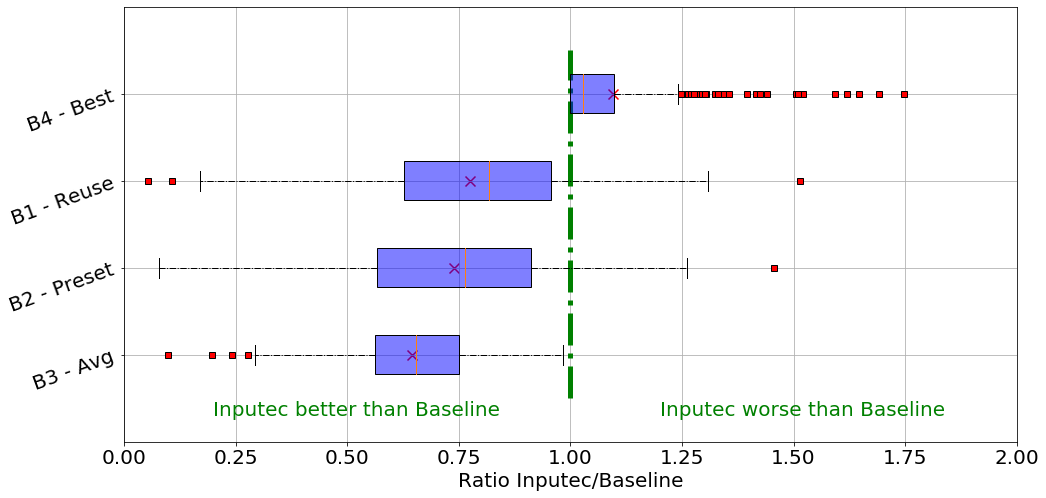

In [61]:
# we aggregate the different ratios, sorted by increasing efficiency
box_res = np.transpose(pd.DataFrame({"mean" : ratio_b3,
                                     "compromise" : ratio_b2,
                                     "model reuse" : ratio_b1,
                                     "min" : ratio_b4}))

# rotation of the text in the ordered axis, to fit the figure in the paper
degrees = 20

# cosmetic choices
red_square = dict(markerfacecolor='r', marker='s')
# figure size
plt.figure(figsize=(16,8))
# add a grid
plt.grid()
plt.boxplot(box_res, flierprops=red_square, 
          vert=False, patch_artist=True, #widths=0.25,
          boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
          whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
# add crosses for average values of distributions
plt.scatter(np.array([np.mean(box_res.iloc[i]) for i in range(4)]), np.arange(1, 5, 1), 
            marker="x", color = "red", alpha = 1, s = 100)
# Limits
plt.ylim(0,5)
plt.xlim(0,2)
# Inputec vs Baseline
plt.vlines(x=1, ymin=0.5, ymax=4.5, linestyle='-.', color='green', linewidth = 5)
plt.text(s = "Inputec worse than Baseline", x = 1.2, y = 0.3, size = 20, color = 'green')
plt.text(s = "Inputec better than Baseline", x = 0.2, y = 0.3, size = 20, color = 'green')
# Labels
plt.xlabel("Ratio Inputec/Baseline", size = 20)
# Ticks of axis
plt.yticks([1, 2, 3, 4], 
           ['B3 - Avg', 'B2 - Preset', 'B1 - Reuse', 'B4 - Best'],
          size = 20,
          rotation=degrees)
plt.xticks(size = 20)
# save figure in the results folder
plt.savefig("../../results/res_box_baseline.png")
# show the figure
plt.show()

## Figure 5b - Rankings of configurations, baseline vs Inputec

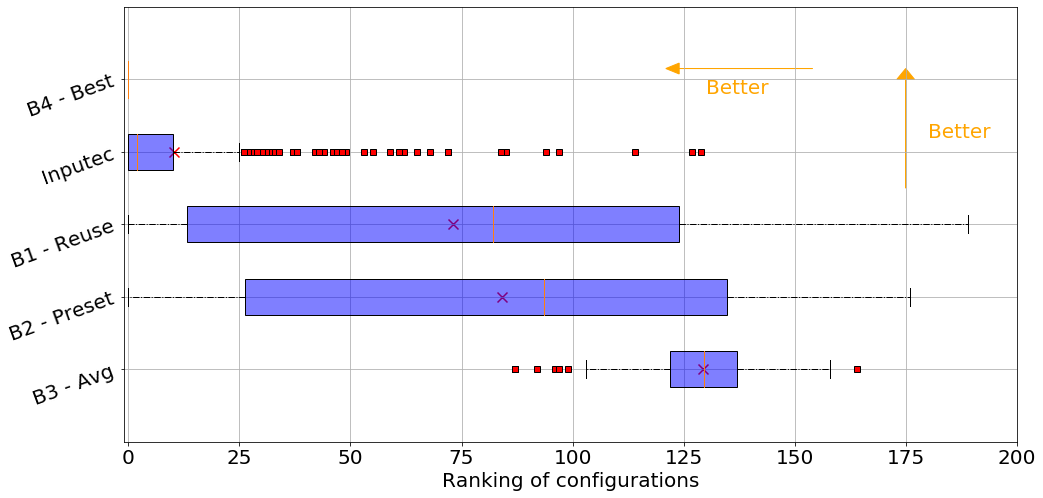

In [62]:
box_res = np.transpose(pd.DataFrame({"mean" : b3_ranks,
                                     "compromise" : b2_ranks,
                                     "model reuse" : b1_ranks,
                                     "inputec" : inputec_ranks,
                                     "min" : b4_ranks}))
red_square = dict(markerfacecolor='r', marker='s')
plt.figure(figsize=(16,8))
plt.grid()
plt.boxplot(box_res, flierprops = red_square, 
          vert = False, patch_artist = True, #widths=0.25,
          boxprops = dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
          whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
plt.scatter(np.array([np.mean(box_res.iloc[i]) for i in range(4)]), np.arange(1, 5, 1), 
            marker="x", color = "red", alpha = 1, s = 100)
plt.ylim(0, 6)
plt.xlim(-1,200)
plt.xlabel("Ranking of configurations", size = 20)
plt.arrow(x = 175, y = 3.5, dx= 0, dy = 1.5, head_width = 4, head_length = .15, color="orange")
plt.text(s = "Better", x = 180, y = 4.2, size = 20, color = 'orange')
plt.arrow(x = 154, y = 5.15, dx= -30, dy = 0, head_width = .15, head_length = 3, color="orange")
plt.text(s = "Better", x = 130, y = 4.8, size = 20, color = 'orange')
plt.yticks([1, 2, 3, 4, 5,], 
           ['B3 - Avg', 'B2 - Preset', 'B1 - Reuse', 'Inputec', 'B4 - Best'], 
           size=20,
          rotation=degrees)
plt.xticks(size=20)
plt.savefig("../../results/res_box_baseline_rank.png")
plt.show()

#### Statistical tests - Welch t-test

In [63]:
stats.ttest_ind(inputec_ranks, b3_ranks, equal_var = False)

Ttest_indResult(statistic=-98.33378880835407, pvalue=0.0)

In [64]:
stats.ttest_ind(inputec_ranks, b2_ranks, equal_var = False)

Ttest_indResult(statistic=-23.142523311285814, pvalue=1.5717544825159734e-77)

In [65]:
stats.ttest_ind(inputec_ranks, b1_ranks, equal_var = False)

Ttest_indResult(statistic=-20.136258521891495, pvalue=3.75942856751269e-64)

Three Welch’s t-tests confirm that the rankings of Inputecare significantly different from B1, B2 and B3 rankings. 

We reject the null hypothesis (i.e. the equality of performances).

## Variants of Inputec

### M2 - Cost effective Inputec

#### 20 configurations per videos instead of 201 

In [66]:
nb_config_ce = 20

def gen_dataset_ce(inputs_names):

    res = pd.DataFrame(np.zeros(nb_config_ce*len(inputs_names)*nb_col)
                       .reshape(nb_config_ce*len(inputs_names), nb_col))
    res.columns = name_col

    for i in range(len(inputs_names)):
        video_name = inputs_names[i]
        index_video = np.where(np.array([v[:-4] for v in v_names], str)==video_name)[0][0]
        sizes = listVideo[index_video][predDimension]
        video_prop = np.array(meta_perf.loc[video_name][1:], float)
        moy = np.mean(sizes)
        std = np.std(sizes)
        for config_id in range(nb_config_ce):
            #config_rank = sorted_config[config_id]
            val = list(tuple(video_prop) + tuple(val_config.loc[config_id]))
            val.append((sizes[config_id]-moy)/std)
            res.loc[i*nb_config_ce+config_id] = val
    return res

training_data_ce = gen_dataset_ce(train_index)
test_data_ce = gen_dataset_ce(test_index)

print("Training size : ", training_data_ce.shape[0])
print("Test size : ", test_data_ce.shape[0])

test_data_ce

Training size :  20940
Test size :  7000


,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category,cabac,...,direct,weightb,open_gop,weightp,scenecut,rc_lookahead,mbtree,qpmax,aq-mode,bitrate
0,-0.678859,-0.318559,-0.862625,-0.999133,0.405878,-1.237567,-0.637153,-1.232460,1.494379,-1.463056,...,-1.676144,-2.038047,0.0,-1.652973,-1.737814,-1.112186,-1.168183,0.0,-1.479994,3.312123
1,-0.678859,-0.318559,-0.862625,-0.999133,0.405878,-1.237567,-0.637153,-1.232460,1.494379,0.683471,...,-0.333893,0.490641,0.0,-0.339741,-1.737814,1.522974,0.855996,0.0,0.675649,-0.451564
2,-0.678859,-0.318559,-0.862625,-0.999133,0.405878,-1.237567,-0.637153,-1.232460,1.494379,0.683471,...,1.008358,0.490641,0.0,-0.339741,-1.737814,-0.672993,0.855996,0.0,-1.479994,-0.263172
3,-0.678859,-0.318559,-0.862625,-0.999133,0.405878,-1.237567,-0.637153,-1.232460,1.494379,0.683471,...,-0.333893,0.490641,0.0,-0.339741,-1.737814,-0.672993,0.855996,0.0,-1.479994,-0.248645
4,-0.678859,-0.318559,-0.862625,-0.999133,0.405878,-1.237567,-0.637153,-1.232460,1.494379,0.683471,...,1.008358,0.490641,0.0,-0.339741,0.575435,0.205394,-1.168183,0.0,0.675649,-0.505683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,-0.678859,3.192173,-0.765307,0.783781,-1.022175,-0.471972,0.051558,0.084609,1.272052,0.683471,...,-0.333893,0.490641,0.0,0.973490,0.575435,0.644587,0.855996,0.0,0.675649,-0.478344
6996,-0.678859,3.192173,-0.765307,0.783781,-1.022175,-0.471972,0.051558,0.084609,1.272052,0.683471,...,1.008358,0.490641,0.0,0.973490,0.575435,0.644587,0.855996,0.0,-1.479994,0.129613
6997,-0.678859,3.192173,-0.765307,0.783781,-1.022175,-0.471972,0.051558,0.084609,1.272052,0.683471,...,1.008358,0.490641,0.0,-0.339741,0.575435,0.644587,0.855996,0.0,0.675649,-0.455590
6998,-0.678859,3.192173,-0.765307,0.783781,-1.022175,-0.471972,0.051558,0.084609,1.272052,0.683471,...,1.008358,0.490641,0.0,0.973490,0.575435,0.644587,0.855996,0.0,0.675649,-0.465430


In [67]:
X_train_ce = np.array(training_data_ce.drop(["bitrate"],axis=1), float)
y_train_ce = np.array(training_data_ce["bitrate"], float)

X_test_ce = np.array(test_data_ce.drop(["bitrate"],axis=1), float)
y_test_ce = np.array(test_data_ce["bitrate"], float)

In [68]:
LA_ce = RandomForestRegressor()

LA_ce.fit(X_train_ce, y_train_ce)

y_pred_ce = LA_ce.predict(X_test_ce)

In [69]:
print(LA_ce.feature_importances_)

[2.58104138e-02 1.35293465e-02 8.85210472e-03 7.71580050e-03
 1.56298774e-01 8.43570731e-02 4.42156427e-02 4.01466326e-02
 1.83962025e-02 1.48927494e-02 1.86220438e-03 1.72920926e-01
 5.36078564e-03 1.74794866e-03 3.45086998e-01 1.93489169e-04
 6.55001699e-03 5.72254647e-03 3.87280816e-04 8.16225410e-04
 4.10620441e-03 2.88451723e-03 1.81092608e-04 2.44466929e-04
 5.75989869e-04 2.72102964e-04 0.00000000e+00 1.61334658e-03
 2.96307753e-03 6.76941922e-03 1.05046271e-02 0.00000000e+00
 1.50219944e-02]


In [70]:
np.mean(np.abs(y_pred_ce-y_test_ce))

0.2587928911994988

In [71]:
print(name_col)

['SLEEQ_DMOS', 'BANDING_DMOS', 'WIDTH', 'HEIGHT', 'SPATIAL_COMPLEXITY', 'TEMPORAL_COMPLEXITY', 'CHUNK_COMPLEXITY_VARIATION', 'COLOR_COMPLEXITY', 'video_category', 'cabac', 'ref', 'deblock', 'analyse', 'me', 'subme', 'mixed_ref', 'me_range', 'trellis', '8x8dct', 'fast_pskip', 'chroma_qp_offset', 'bframes', 'b_pyramid', 'b_adapt', 'direct', 'weightb', 'open_gop', 'weightp', 'scenecut', 'rc_lookahead', 'mbtree', 'qpmax', 'aq-mode', 'bitrate']


In [72]:
# the performance values for the configuration chosen by Inputec, for the test set of videos
inputec_m2 = []

# the performance rankings for the configuration chosen by Inputec, for the test set of videos
inputec_m2_ranks = []

# for each video in the test set
for ti in test_index:
    # we retrieve the test index
    index_video = np.where(np.array([v[:-4] for v in v_names], str)==ti)[0][0]
    # list of predictions for inputec
    pred_inputec = []
    # for each configuration
    for i in range(nb_config):
        # we add input properties to the configurations
        video_prop = list(tuple(meta_perf.loc[ti][1:])+tuple(val_config.loc[i]))
        # we predict the value associated to the configuration
        pred_inputec.append(LA_ce.predict(np.array(video_prop, float).reshape(1, 33)))
    # sorted performances
    sorted_perfs = sorted(listVideo[index_video][predDimension])
    # the performance of the configuration chosen by Inputec
    perf = listVideo[index_video].loc[np.argmin(pred_inputec)][predDimension]
    # we add it to the perf array
    inputec_m2.append(perf)
    # the related ranking (between 0 and 200, hopefully close to 0)
    inputec_m2_ranks.append(find_rank(sorted_perfs, perf))

In [73]:
pd.Series(inputec_m2).describe()

count      350.000000
mean      7505.176486
std      12451.631532
min         17.470000
25%        948.537500
50%       2397.540000
75%       8396.222500
max      94019.600000
dtype: float64

In [74]:
pd.Series(inputec_m2_ranks).describe()

count    350.000000
mean      34.762857
std       28.776250
min        0.000000
25%       11.000000
50%       28.000000
75%       53.000000
max      145.000000
dtype: float64

### M3 - Property selection

#### Only keep affordable properties in the model - drop SLEEQ MOS and Banding MOS

In [75]:
name_col = list(meta_perf.columns)[3:]

for vcc in val_config.columns:
    name_col.append(vcc)

name_col.append("bitrate")

nb_col = len(name_col)
nb_config = 201

def gen_dataset(inputs_names):
    
    res = pd.DataFrame(np.zeros(nb_config*len(inputs_names)*nb_col).reshape(nb_config*len(inputs_names), nb_col))
    res.columns = name_col

    for i in range(len(inputs_names)):
        video_name = inputs_names[i]
        index_video = np.where(np.array([v[:-4] for v in v_names], str)==video_name)[0][0]
        sizes = listVideo[index_video][predDimension]
        sorted_config = sorted(range(len(sizes)), key=lambda k: sizes[k])
        video_prop = np.array(meta_perf.loc[video_name][3:], float)
        moy = np.mean(sizes)
        std = np.std(sizes)            
        for config_id in range(len(sorted_config)):
            config_rank = sorted_config[config_id]
            val = list(tuple(video_prop) + tuple(val_config.loc[config_id]))
            val.append((sizes[config_id]-moy)/std)
            res.loc[i*nb_config+config_id] = val
    return res

training_data_m3 = gen_dataset(train_index)
test_data_m3 = gen_dataset(test_index)

print("Training size : ", training_data_m3.shape[0])
print("Test size : ", test_data_m3.shape[0])

test_data_m3

Training size :  210447
Test size :  70350


,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category,cabac,ref,deblock,...,direct,weightb,open_gop,weightp,scenecut,rc_lookahead,mbtree,qpmax,aq-mode,bitrate
0,-0.862625,-0.999133,0.405878,-1.237567,-0.637153,-1.232460,1.494379,-1.463056,-0.773348,-1.551346,...,-1.676144,-2.038047,0.0,-1.652973,-1.737814,-1.112186,-1.168183,0.0,-1.479994,3.312123
1,-0.862625,-0.999133,0.405878,-1.237567,-0.637153,-1.232460,1.494379,0.683471,-0.585615,0.644573,...,-0.333893,0.490641,0.0,-0.339741,-1.737814,1.522974,0.855996,0.0,0.675649,-0.451564
2,-0.862625,-0.999133,0.405878,-1.237567,-0.637153,-1.232460,1.494379,0.683471,-0.585615,0.644573,...,1.008358,0.490641,0.0,-0.339741,-1.737814,-0.672993,0.855996,0.0,-1.479994,-0.263172
3,-0.862625,-0.999133,0.405878,-1.237567,-0.637153,-1.232460,1.494379,0.683471,-0.585615,-1.551346,...,-0.333893,0.490641,0.0,-0.339741,-1.737814,-0.672993,0.855996,0.0,-1.479994,-0.248645
4,-0.862625,-0.999133,0.405878,-1.237567,-0.637153,-1.232460,1.494379,0.683471,2.042646,0.644573,...,1.008358,0.490641,0.0,-0.339741,0.575435,0.205394,-1.168183,0.0,0.675649,-0.505683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70345,-0.765307,0.783781,-1.022175,-0.471972,0.051558,0.084609,1.272052,0.683471,-0.585615,0.644573,...,1.008358,0.490641,0.0,-0.339741,0.575435,-0.233799,0.855996,0.0,0.675649,-0.837034
70346,-0.765307,0.783781,-1.022175,-0.471972,0.051558,0.084609,1.272052,0.683471,-0.585615,-1.551346,...,1.008358,0.490641,0.0,-0.339741,0.575435,0.205394,0.855996,0.0,0.675649,-0.765739
70347,-0.765307,0.783781,-1.022175,-0.471972,0.051558,0.084609,1.272052,0.683471,-0.022416,0.644573,...,-0.333893,0.490641,0.0,-0.339741,0.575435,0.205394,0.855996,0.0,0.675649,-0.507644
70348,-0.765307,0.783781,-1.022175,-0.471972,0.051558,0.084609,1.272052,-1.463056,-0.397882,-1.551346,...,1.008358,0.490641,0.0,0.973490,0.575435,0.205394,-1.168183,0.0,0.675649,0.836881


In [76]:
X_train_m3 = np.array(training_data_m3.drop(["bitrate"],axis=1), float)
y_train_m3 = np.array(training_data_m3["bitrate"], float)

X_test_m3 = np.array(test_data_m3.drop(["bitrate"],axis=1), float)
y_test_m3 = np.array(test_data_m3["bitrate"], float)

In [77]:
LA_m3 = RandomForestRegressor()

LA_m3.fit(X_train_m3, y_train_m3)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [78]:
y_pred_m3 = LA_m3.predict(X_test_m3)

In [79]:
print(LA_m3.feature_importances_)

[8.75669981e-03 7.00535957e-03 1.04071041e-01 7.49649653e-02
 3.45982799e-02 3.19968676e-02 1.64322537e-02 4.27870461e-02
 2.81592001e-03 6.70882563e-04 3.00687591e-03 2.30621608e-03
 5.02930843e-01 7.74346302e-04 4.47336832e-04 6.93324820e-03
 7.34575799e-04 2.92913570e-03 3.23047550e-03 1.26097616e-02
 9.92219784e-03 8.04224890e-03 2.65946478e-03 6.62996864e-03
 0.00000000e+00 1.44786159e-03 9.93448018e-04 4.67711998e-03
 4.03809753e-02 0.00000000e+00 6.52445839e-02]


In [80]:
np.mean(np.abs(y_pred_m3-y_test_m3))

0.2803430612686696

In [81]:
# the performance values for the configuration chosen by Inputec, for the test set of videos
inputec_m3 = []

# the performance rankings for the configuration chosen by Inputec, for the test set of videos
inputec_m3_ranks = []

# for each video in the test set
for ti in test_index:
    # we retrieve the test index
    index_video = np.where(np.array([v[:-4] for v in v_names], str)==ti)[0][0]
    # list of predictions for inputec
    pred_inputec = []
    # for each configuration
    for i in range(nb_config):
        # we add input properties to the configurations
        video_prop = list(tuple(meta_perf.loc[ti][3:])+tuple(val_config.loc[i]))
        # we predict the value associated to the configuration
        pred_inputec.append(LA_m3.predict(np.array(video_prop, float).reshape(1, 31)))
    # sorted performances
    sorted_perfs = sorted(listVideo[index_video][predDimension])
    # the performance of the configuration chosen by Inputec
    perf = listVideo[index_video].loc[np.argmin(pred_inputec)][predDimension]
    # we add it to the perf array
    inputec_m3.append(perf)
    # the related ranking (between 0 and 200, hopefully close to 0)
    inputec_m3_ranks.append(find_rank(sorted_perfs, perf))

In [82]:
pd.Series(inputec_m3).describe()

count      350.000000
mean      7160.058743
std      12262.420770
min         19.080000
25%        829.852500
50%       2181.430000
75%       7712.815000
max      88511.370000
dtype: float64

In [83]:
pd.Series(inputec_m3_ranks).describe()

count    350.000000
mean      11.611429
std       21.840209
min        0.000000
25%        0.000000
50%        3.000000
75%       11.000000
max      142.000000
dtype: float64